In [1]:
import gym
from gym import envs
import numpy as np 
import datetime


import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from time import sleep
from numpy import random
import time
plt.rcParams.update({'font.size': 16})
import mdptoolbox, mdptoolbox.example


In [6]:
def play_episodes(enviorment, n_episodes, policy, random = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        enviorment: openAI GYM object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # flag to check if the game is finished
        terminated = False
        
        # reset the enviorment every time when playing a new episode
        state = enviorment.reset()
        
        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = enviorment.action_space.sample()
            else:
                action = policy[state]

            # take the next step
            next_state, reward,  terminated, info = enviorment.step(action)
            
#             enviorment.render()
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state
            
            # if game is over with positive reward then add 1.0 in wins
            if terminated and reward == 20:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward

## Value Iteration

In [7]:
def one_step_lookahead(env, state, V , discount_factor = 0.99):
    """
    Helper function to  calculate state-value function
    
    Arguments:
        env: openAI GYM Enviorment object
        state: state to consider
        V: Estimated Value for each state. Vector of length nS
        discount_factor: MDP discount factor
        
    Return:
        action_values: Expected value of each action in a state. Vector of length nA
    """
    
    # initialize vector of action values
    action_values = np.zeros(env.nA)
    
    # loop over the actions we can take in an enviorment 
    for action in range(env.nA):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))
            
    return action_values

In [8]:
def update_policy(env, policy, V, discount_factor):
    
    """
    Helper function to update a given policy based on given value function.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to update.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy: Updated policy based on the given state-Value function 'V'.
    """
    
    for state in range(env.nS):
        # for a given state compute state-action value.
        action_values = one_step_lookahead(env, state, V, discount_factor)
        
        # choose the action which maximizez the state-action value.
        policy[state] =  np.argmax(action_values)
        
    return policy

In [9]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        optimal_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize value fucntion
    V = np.zeros(env.nS)
    
    # iterate over max_iterations
    for i in range(max_iteration):
        
        #  keep track of change with previous value function
        prev_v = np.copy(V) 
    
        # loop over all states
        for state in range(env.nS):
            
            # Asynchronously update the state-action value
            action_values = one_step_lookahead(env, state, V, discount_factor)
            
            # Synchronously update the state-action value
#             action_values = one_step_lookahead(env, state, prev_v, discount_factor)
            
            # select best action to perform based on highest state-action value
            best_action_value = np.max(action_values)
            
            # update the current state-value fucntion
            V[state] =  best_action_value
            
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            # if values of 'V' not changing after one iteration
            if (np.all(np.isclose(V, prev_v))):
#                 print('Value converged at iteration %d' %(i+1))
                break

    # intialize optimal policy
    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    
    # update the optimal polciy according to optimal value function 'V'
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return V, optimal_policy

In [22]:
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / test_count

def trainQLearning(P, R, test_count, discount=0.9, alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    from hiive.mdptoolbox.mdp import QLearning
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = evaluate_policy(P, R, q.policy, test_count)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

## Policy Iteration

In [23]:
def mdpPI(gamma,states):
    value_f=[]
    iters=[]
    times=[]
    P, R = mdptoolbox.example.forest(S=states)
    pi = mdptoolbox.mdp.PolicyIteration(P, R, gamma)
    pi.run()
    value_f.append(evaluate_policy(P, R, pi.policy, test_count=100, gamma=gamma)) #valuate_policy(P, R, pi.policy, test_count=100, gamma=gamma)
    policy = pi.policy
    iters.append(pi.iter)
    times.append(pi.time*1000)
    return value_f,times,iters

In [24]:
convergence_iters_09=[]
convergence_time_09=[]
convergence_rewards_09=[]
for i in range(100,500, 100):
    training_rewards_gamma_09,training_times_gamma_09,training_iters_gamma_09 =mdpPI(0.9,i)
    convergence_iters_09.append(training_iters_gamma_09)
    convergence_time_09.append(training_times_gamma_09)
    convergence_rewards_09.append(training_rewards_gamma_09)

convergence_iters_06=[]
convergence_time_06=[]
convergence_rewards_06=[]
for i in range(100,500, 100):
    training_rewards_gamma_06,training_times_gamma_06,training_iters_gamma_06 =mdpPI(0.6,i)
    convergence_iters_06.append(training_iters_gamma_06)
    convergence_time_06.append(training_times_gamma_06)
    convergence_rewards_06.append(training_rewards_gamma_06)

convergence_iters_04=[]
convergence_time_04=[]
convergence_rewards_04=[]
for i in range(100,500, 100):
    training_rewards_gamma_04,training_times_gamma_04,training_iters_gamma_04 =mdpPI(0.4,i)
    convergence_iters_04.append(training_iters_gamma_04)
    convergence_time_04.append(training_times_gamma_04)
    convergence_rewards_04.append(training_rewards_gamma_04)
    
convergence_iters_01=[]
convergence_time_01=[]
convergence_rewards_01=[]
for i in range(100,500, 100):
    training_rewards_gamma_01,training_times_gamma_01,training_iters_gamma_01 =mdpPI(0.1,i)
    convergence_iters_01.append(training_iters_gamma_01)
    convergence_time_01.append(training_times_gamma_01)
    convergence_rewards_01.append(training_rewards_gamma_01)

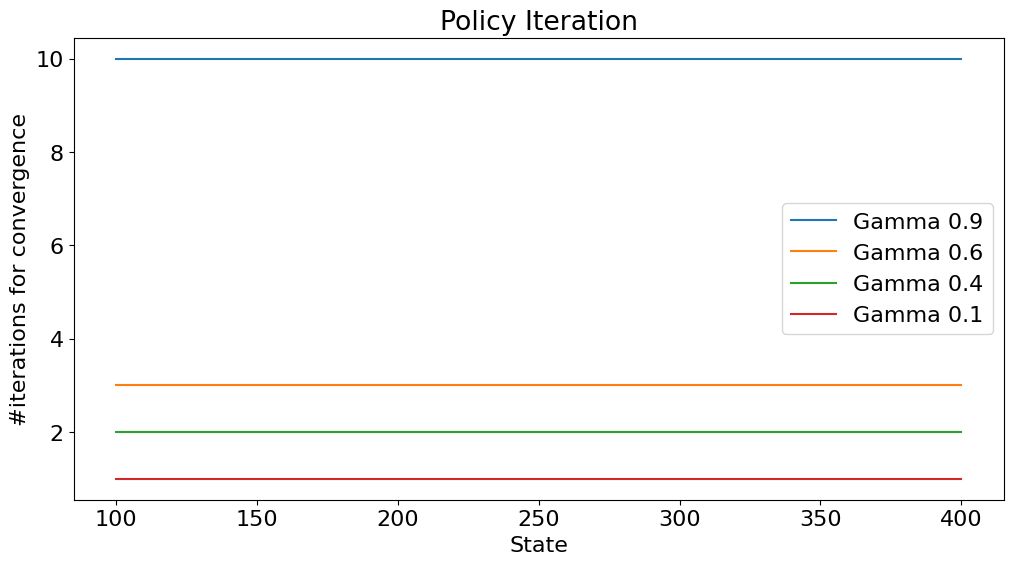

In [25]:
plt.plot(range(100,500, 100), convergence_iters_09,label='Gamma 0.9')
plt.plot(range(100,500, 100), convergence_iters_06,label='Gamma 0.6')
plt.plot(range(100,500, 100), convergence_iters_04,label='Gamma 0.4')
plt.plot(range(100,500, 100), convergence_iters_01,label='Gamma 0.1')
plt.xlabel('State')
plt.title('Policy Iteration')
plt.ylabel('#iterations for convergence')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

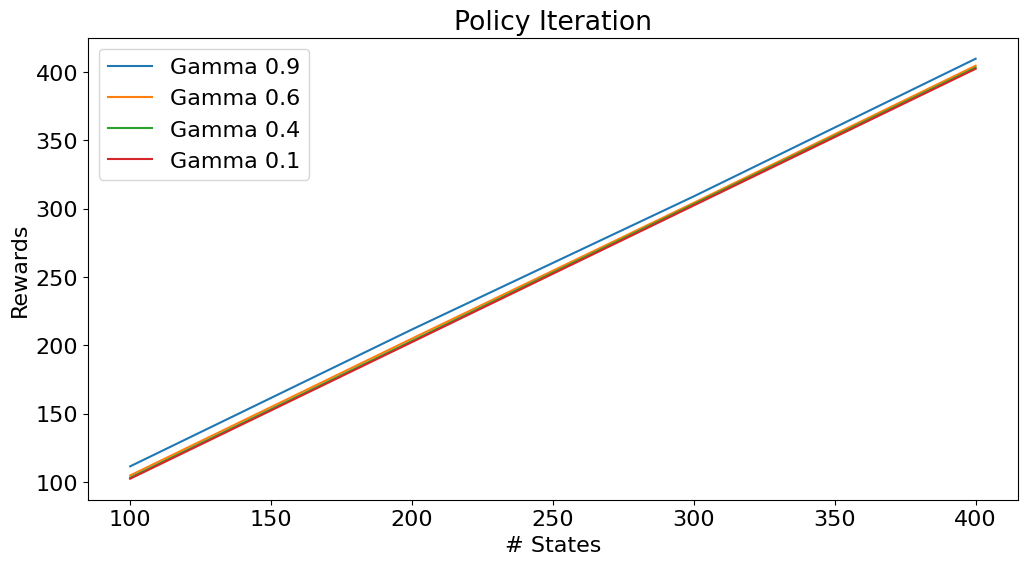

In [26]:
plt.plot(range(100,500, 100), convergence_rewards_09,label='Gamma 0.9')
plt.plot(range(100,500, 100), convergence_rewards_06,label='Gamma 0.6')
plt.plot(range(100,500, 100), convergence_rewards_04,label='Gamma 0.4')
plt.plot(range(100,500, 100), convergence_rewards_01,label='Gamma 0.1')
plt.xlabel('# States')
plt.title('Policy Iteration')
plt.ylabel('Rewards')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

## Value Iteration

In [27]:
def mdpPI(gamma,states):
    value_f=[]
    iters=[]
    times=[]
    P, R = mdptoolbox.example.forest(S=states)
    pi = mdptoolbox.mdp.ValueIteration(P, R, gamma)
    pi.run()
    value_f.append(evaluate_policy(P, R, pi.policy, test_count=100, gamma=gamma)) #valuate_policy(P, R, pi.policy, test_count=100, gamma=gamma)
    policy = pi.policy
    iters.append(pi.iter)
    times.append(pi.time*1000)
    return value_f,times,iters

In [28]:
convergence_iters_09=[]
convergence_time_09=[]
convergence_rewards_09=[]
for i in range(100,500, 100):
    training_rewards_gamma_09,training_times_gamma_09,training_iters_gamma_09 =mdpPI(0.9,i)
    convergence_iters_09.append(training_iters_gamma_09)
    convergence_time_09.append(training_times_gamma_09)
    convergence_rewards_09.append(training_rewards_gamma_09)

convergence_iters_06=[]
convergence_time_06=[]
convergence_rewards_06=[]
for i in range(100,500, 100):
    training_rewards_gamma_06,training_times_gamma_06,training_iters_gamma_06 =mdpPI(0.6,i)
    convergence_iters_06.append(training_iters_gamma_06)
    convergence_time_06.append(training_times_gamma_06)
    convergence_rewards_06.append(training_rewards_gamma_06)

convergence_iters_04=[]
convergence_time_04=[]
convergence_rewards_04=[]
for i in range(100,500, 100):
    training_rewards_gamma_04,training_times_gamma_04,training_iters_gamma_04 =mdpPI(0.4,i)
    convergence_iters_04.append(training_iters_gamma_04)
    convergence_time_04.append(training_times_gamma_04)
    convergence_rewards_04.append(training_rewards_gamma_04)
    
convergence_iters_01=[]
convergence_time_01=[]
convergence_rewards_01=[]
for i in range(100,500, 100):
    training_rewards_gamma_01,training_times_gamma_01,training_iters_gamma_01 =mdpPI(0.1,i)
    convergence_iters_01.append(training_iters_gamma_01)
    convergence_time_01.append(training_times_gamma_01)
    convergence_rewards_01.append(training_rewards_gamma_01)

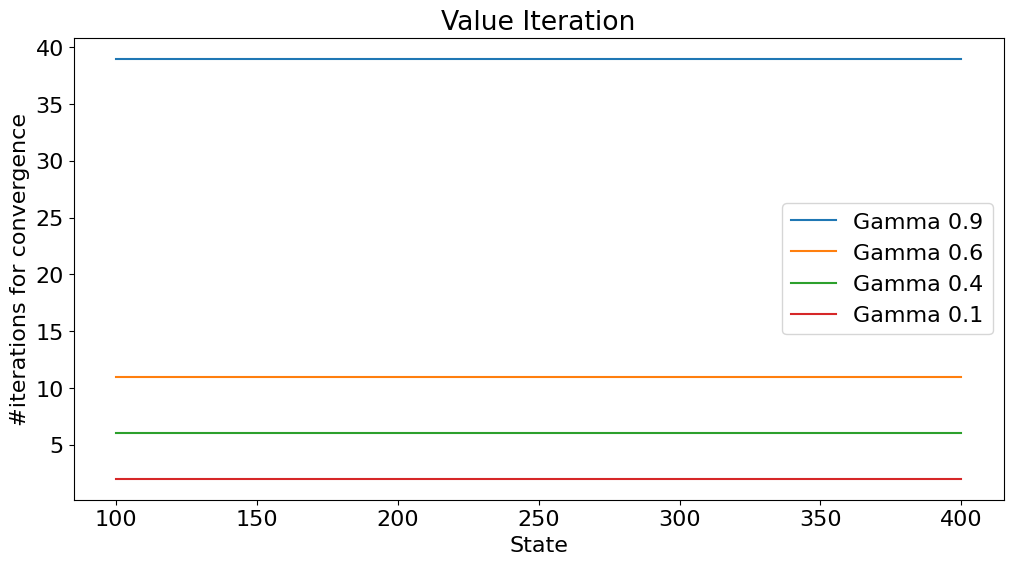

In [29]:
plt.plot(range(100,500, 100), convergence_iters_09,label='Gamma 0.9')
plt.plot(range(100,500, 100), convergence_iters_06,label='Gamma 0.6')
plt.plot(range(100,500, 100), convergence_iters_04,label='Gamma 0.4')
plt.plot(range(100,500, 100), convergence_iters_01,label='Gamma 0.1')
plt.xlabel('State')
plt.title('Value Iteration')
plt.ylabel('#iterations for convergence')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

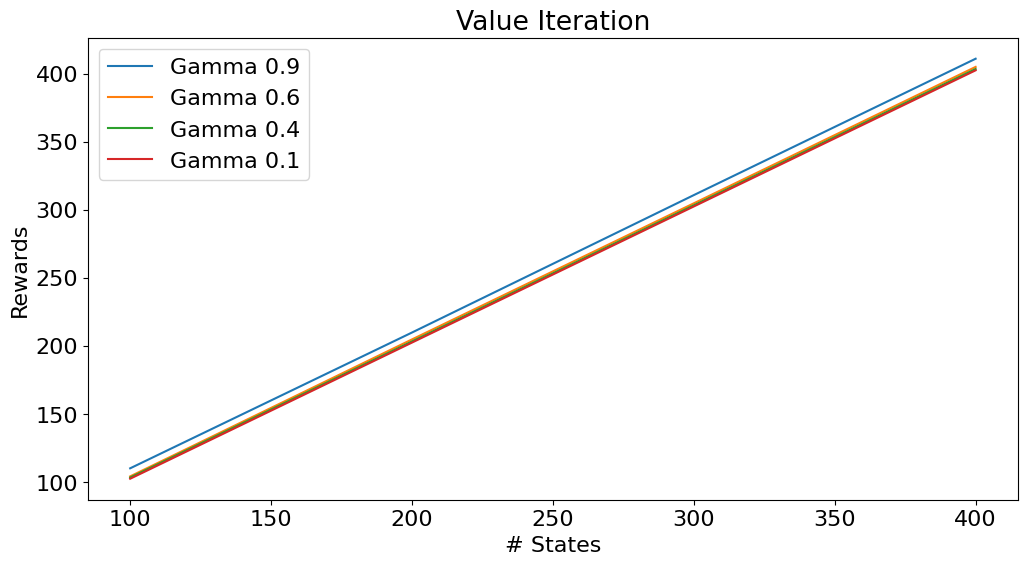

In [30]:
plt.plot(range(100,500, 100), convergence_rewards_09,label='Gamma 0.9')
plt.plot(range(100,500, 100), convergence_rewards_06,label='Gamma 0.6')
plt.plot(range(100,500, 100), convergence_rewards_04,label='Gamma 0.4')
plt.plot(range(100,500, 100), convergence_rewards_01,label='Gamma 0.1')
plt.xlabel('# States')
plt.title('Value Iteration')
plt.ylabel('Rewards')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

## Q Learning

In [31]:
def mdpPI(gamma,states):
    value_f=[]
    iters=[]
    times=[]
    P, R = mdptoolbox.example.forest(S=states)
    pi = mdptoolbox.mdp.QLearning(P, R, gamma)
    pi.run()
    value_f.append(evaluate_policy(P, R, pi.policy, test_count=100, gamma=gamma)) #valuate_policy(P, R, pi.policy, test_count=100, gamma=gamma)
    policy = pi.policy
    iters.append(0)
    times.append(pi.time*1000)
    return value_f,times,iters

In [32]:
convergence_iters_09=[]
convergence_time_09=[]
convergence_rewards_09=[]
for i in range(100,500, 100):
    training_rewards_gamma_09,training_times_gamma_09,training_iters_gamma_09 =mdpPI(0.9,i)
    convergence_iters_09.append(training_iters_gamma_09)
    convergence_time_09.append(training_times_gamma_09)
    convergence_rewards_09.append(training_rewards_gamma_09)

convergence_iters_06=[]
convergence_time_06=[]
convergence_rewards_06=[]
for i in range(100,500, 100):
    training_rewards_gamma_06,training_times_gamma_06,training_iters_gamma_06 =mdpPI(0.6,i)
    convergence_iters_06.append(training_iters_gamma_06)
    convergence_time_06.append(training_times_gamma_06)
    convergence_rewards_06.append(training_rewards_gamma_06)

convergence_iters_04=[]
convergence_time_04=[]
convergence_rewards_04=[]
for i in range(100,500, 100):
    training_rewards_gamma_04,training_times_gamma_04,training_iters_gamma_04 =mdpPI(0.4,i)
    convergence_iters_04.append(training_iters_gamma_04)
    convergence_time_04.append(training_times_gamma_04)
    convergence_rewards_04.append(training_rewards_gamma_04)
    
convergence_iters_01=[]
convergence_time_01=[]
convergence_rewards_01=[]
for i in range(100,500, 100):
    training_rewards_gamma_01,training_times_gamma_01,training_iters_gamma_01 =mdpPI(0.1,i)
    convergence_iters_01.append(training_iters_gamma_01)
    convergence_time_01.append(training_times_gamma_01)
    convergence_rewards_01.append(training_rewards_gamma_01)

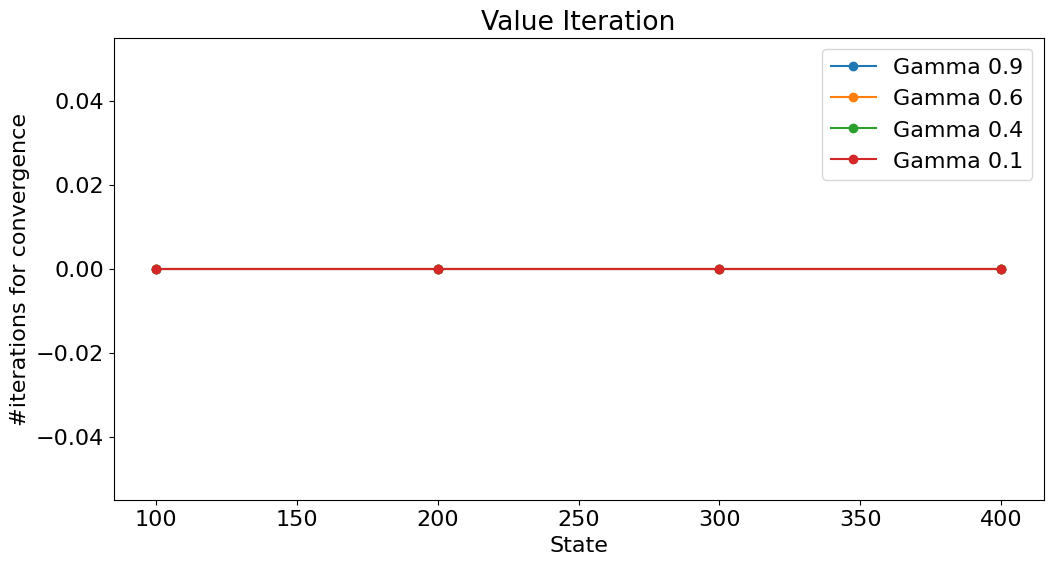

In [33]:
plt.plot(range(100,500, 100), convergence_iters_09,marker='o',label='Gamma 0.9')
plt.plot(range(100,500, 100), convergence_iters_06,marker='o',label='Gamma 0.6')
plt.plot(range(100,500, 100), convergence_iters_04,marker='o',label='Gamma 0.4')
plt.plot(range(100,500, 100), convergence_iters_01,marker='o',label='Gamma 0.1')
plt.xlabel('State')
plt.title('Value Iteration')
plt.ylabel('#iterations for convergence')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

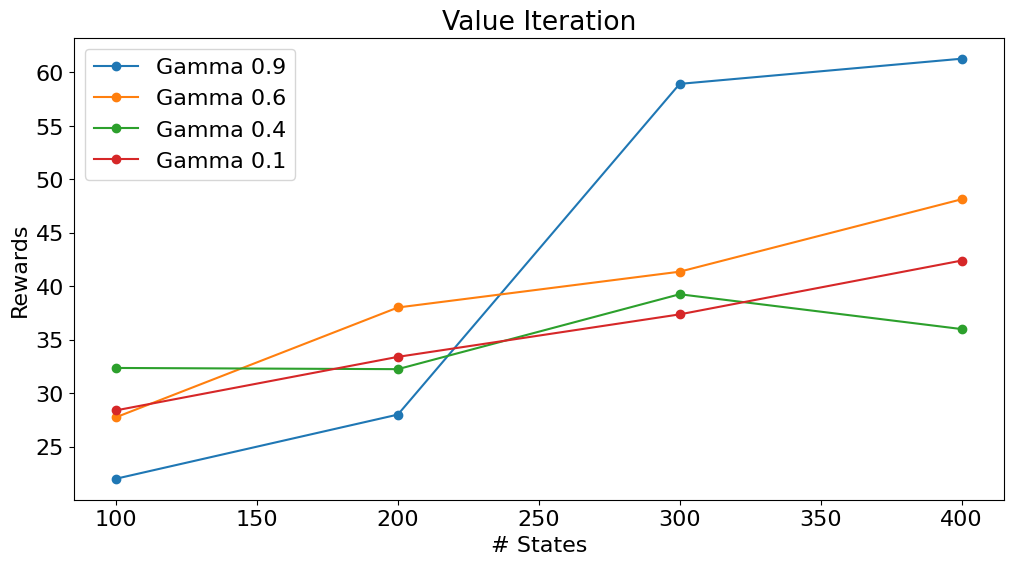

In [34]:
plt.plot(range(100,500, 100), convergence_rewards_09,marker='o',label='Gamma 0.9')
plt.plot(range(100,500, 100), convergence_rewards_06,marker='o',label='Gamma 0.6')
plt.plot(range(100,500, 100), convergence_rewards_04,marker='o',label='Gamma 0.4')
plt.plot(range(100,500, 100), convergence_rewards_01,marker='o',label='Gamma 0.1')
plt.xlabel('# States')
plt.title('Value Iteration')
plt.ylabel('Rewards')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [37]:
def run_Forest(states, test_count):
    
    # New way
    print('Q LEARNING WITH FOREST MANAGEMENT ' + str(states) + ' STATES ')
    P, R = mdptoolbox.example.forest(S=states,p=0.01)
    eps = [0.05,0.15,0.25,0.5,0.75,0.95]
    iters = [10000, 100000]#, 1000000, 10000000]
    q_df = trainQLearning(P, R, test_count, discount=0.9, epsilon=eps, n_iter=iters)
    
    # print('Forest Management ' + str(states) + ' states - Q-learning Table')
    # print(q_df)
    
    fig = plt.figure()
    for frame in [q_df[(q_df.Epsilon == 0.05)], q_df[(q_df.Epsilon == 0.15)], q_df[(q_df.Epsilon == 0.25)], q_df[(q_df.Epsilon == 0.50)], q_df[(q_df.Epsilon == 0.75)], q_df[(q_df.Epsilon == 0.95)]]:
        plt.plot(frame['Iterations'], frame['Reward'],marker='o')
    labels = ["epsilon=" + str(x) for x in eps]
    plt.title('Forest Management ' + str(states) + ' states - Q Learning - Initial Epsilon')
    plt.legend(labels,loc='lower right')
    plt.xlabel('Iterations')
    fig=plt.gcf()
    fig.set_size_inches(12,6)
    plt.ylabel('Reward')
    plt.show()
    
    q_df[(q_df.Iterations == 10000000)].plot(x='Epsilon', y='Time',legend=None,xlabel="Epsilon",ylabel="Time",title="Forest Management " + str(states) + " - Q Learning",marker='o',figsize=(12,6))
    
    return

In [38]:
run_Forest(500, 1000) # States, test_count

STARTING FOREST MANAGEMENT 20 STATES
Q LEARNING WITH FOREST MANAGEMENT 500 STATES 


KeyboardInterrupt: 